## Trabajo Práctico 1

### Fecha de entrega: 02/10


1. Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.

a) Verifique si la red aprendió las imágenes enseñadas.

b) Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes
aprendidas: agregado de ruido, elementos borrados o agregados.

c) Evalúe la existencia de estados espurios en la red: patrones inversos y
combinaciones de un número impar de patrones. (Ver Spurious States, en la sección
2.2, Hertz, Krogh & Palmer, pág. 24).

d) Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de
aprender todas las imágenes? Explique.

## Desarrollo


Se escribe la función que permite convertir bitmaps en imagenes de un tamaño definido, la función que convierte las imágenes en un arreglo de 1s y -1s, y una función que toma un arreglo de -1s y 1s y los representa como una imagen

In [38]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
def pad_image(file_path, target_size=(60, 50)):
    image = Image.open(file_path)
    width, height = image.size
    pad_width = (target_size[0] - width) // 2
    pad_height = (target_size[1] - height) // 2

    # Pad the image to the target size
    padded_image = ImageOps.expand(image, border=(pad_width, pad_height), fill=0)
    padded_image = padded_image.crop((0, 0, target_size[0], target_size[1]))
    return padded_image

def bmp_to_list(image):
    # Open the image using PIL
    #image = Image.open(image)

    # Convert the image to a numpy array
    array = np.array(image)
    # Convert booleans to +1 and -1
    array = np.where(array == 0, -1, array)

    # Flatten the array
    array = array.ravel()

    # Convert numpy array to simple list
    array = array.tolist()

    # Replace each -1 in the least with a 1 and each 1 with a -1
    for i in range(len(array)):
        if array[i] == -1:
            array[i] = 1
        else:
            array[i] = -1

    return array

def create_composite_image(image, target_size = (60, 50)):

    image_array = np.array(image)  # Convert image to NumPy array
    # Inverts the image (0s become 255s and 255s become 0s)
    image_array = 255 - image_array
    # Reshape the image to the target size
    reshaped_image = image_array.reshape(target_size[1], target_size[0])

    # Display the image using matplotlib
    plt.figure(figsize=(5, 5))
    plt.imshow(reshaped_image, cmap='gray')
    # plt.axis('off')  # Hide the axis
    plt.show()

# Example usage
# Assuming padded_image is already defined and contains the image
#for image in image_list :
#    create_composite_image(image, (60, 50))


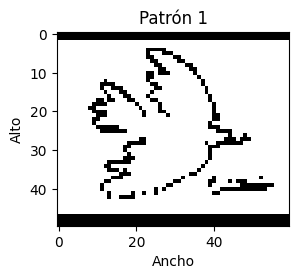

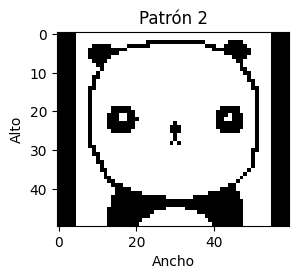

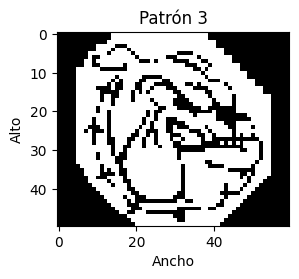

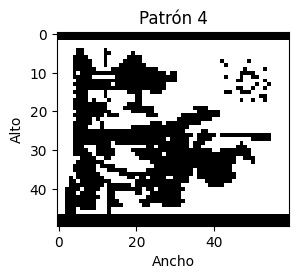

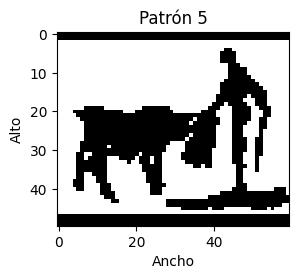

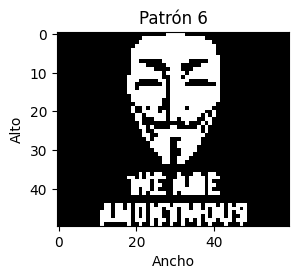

In [39]:
import os

# Define the path to the 'images' folder
folder_path = 'imagenes'

# Create an empty list to store the arrays
image_list = []
padded_image_list = []

# Iterate over the files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file has the '.bmp' extension
    if file_name.endswith('.bmp'):
        # Get the full file path
        file_path = os.path.join(folder_path, file_name)
        image = pad_image(file_path)
        padded_image_list.append(image)
        # Call bmp_to_array and append the result to the list
        image_array = bmp_to_list(image)
        image_list.append(image_array)
for padded_image in padded_image_list:
    plt.figure(figsize=(3,3))
    plt.imshow(np.array(padded_image), cmap='gray')
    # change dimensions of the plot
    ## plt.axis('off')  # Hide the axis
    plt.xlabel("Ancho")
    plt.ylabel("Alto")
    plt.title(f'Patrón {padded_image_list.index(padded_image)+1}')
    plt.show() 

In [40]:
class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))
    def train(self,patterns, eta = 1):
        for pattern in patterns:
            self.weights += eta * np.outer(pattern, pattern)
        np.fill_diagonal(self.weights, 0)    
    def run(self, pattern):
        new_pattern = pattern.copy()
        indexes = np.random.permutation(self.num_neurons)
        for index in indexes:
            weighted_value = np.dot(self.weights[index], new_pattern)
            new_pattern[index] = 1 if weighted_value > 0 else -1
        return new_pattern
    def run_syncronically(self, pattern):
        new_pattern = pattern.copy()
        weighted_value = np.dot(self.weights, new_pattern)
        new_pattern = np.where(weighted_value > 0, 1, -1)
        return new_pattern

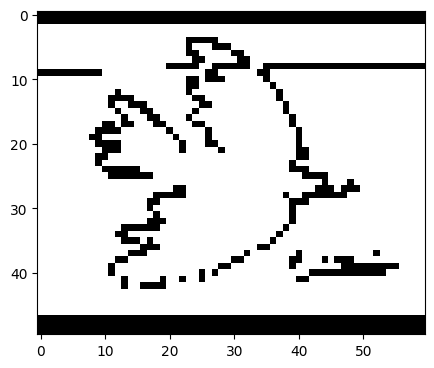

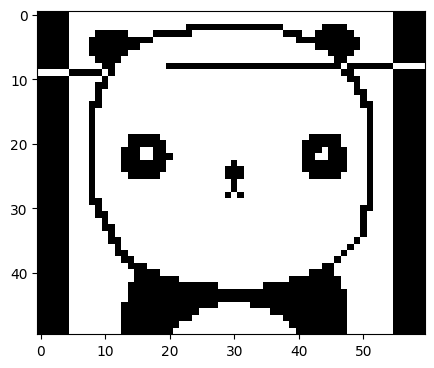

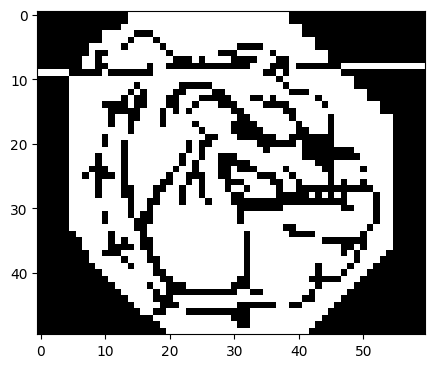

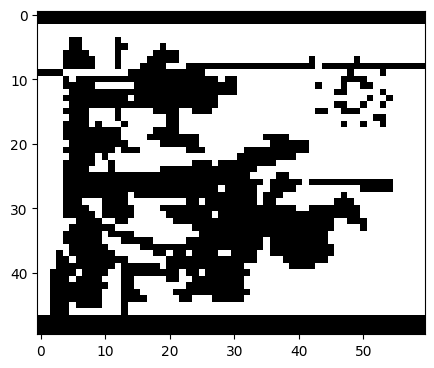

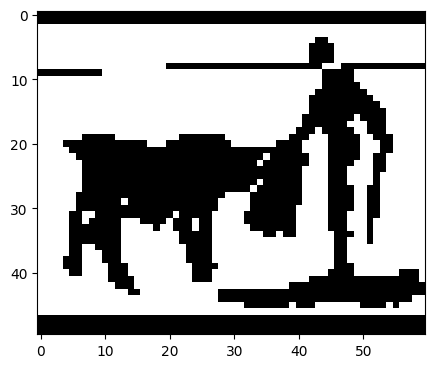

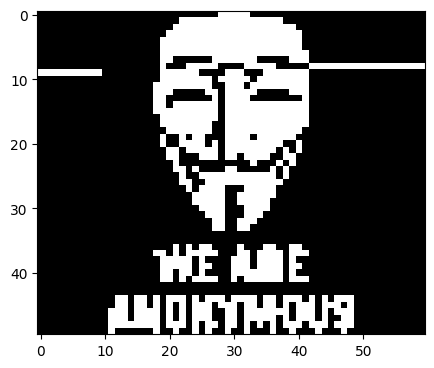

In [41]:
num_neurons = 60 * 50
num_patterns = len(image_list)

hopfield_network = HopfieldNetwork(num_neurons)
hopfield_network.train(image_list, 200)

## Genero un patrón ruidoso
noisy_pattern = image_list.copy()
for pattern in noisy_pattern:
    # agrego una banda negra de 1500 pixeles
    pattern[500:550] = -np.array(pattern[500:550])
    create_composite_image(pattern)



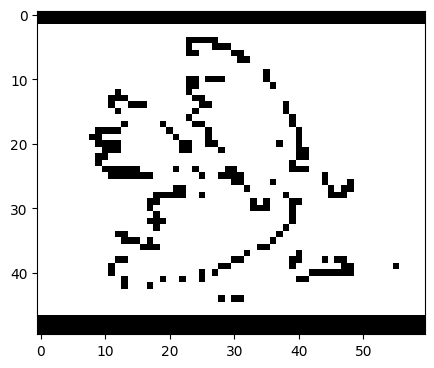

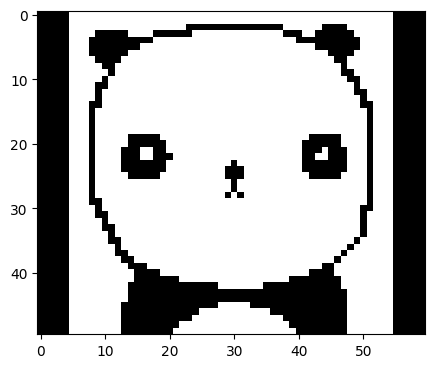

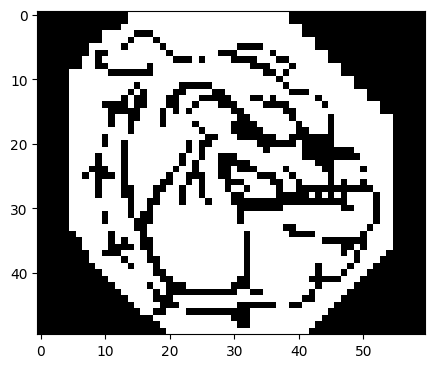

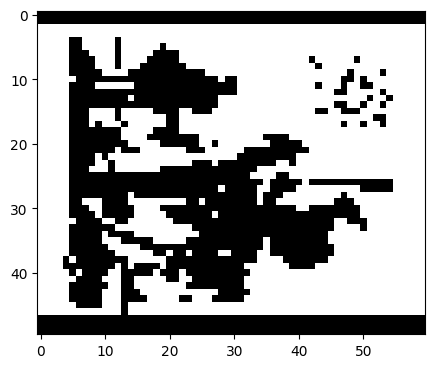

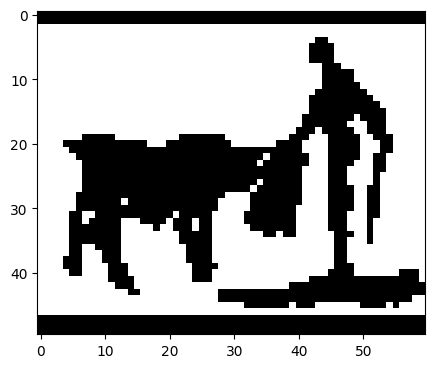

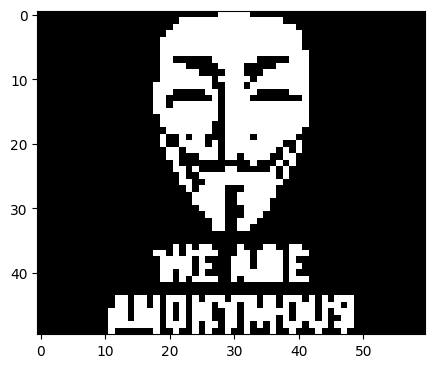

In [42]:
for pattern in noisy_pattern:
    create_composite_image(hopfield_network.run(pattern))

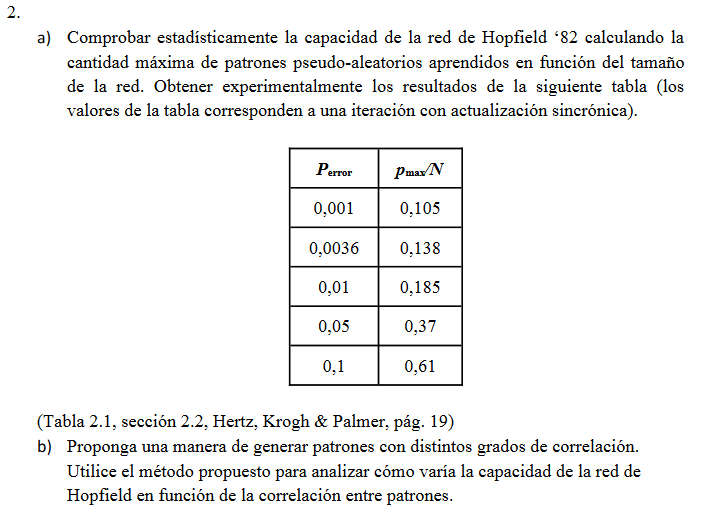

## Tips:
$Capacidad := P_{max}/N$

N cantidad de neuronas, M cantidad de patrones, $P_{max}$ es la cantidad máxima de patrones para su respectivo $P_{error}$ 

$E = \frac{\# Errores Totales}{N\cdot M}$

E va entre 0 y 1, se pide que $E < P_{error}$

### Estructura: 
1. Construyo $\hat{P}, \hat{P}_i = +-1, P(\hat{P}_i = 1) = 1/2$
2. Enseño $\hat{P}$
3. Actualización sincrónica 
4. Computo E
5. Pmax $\impliedby$ Pmax +1
 

In [61]:
from tabulate import tabulate
# Número de neuronas en la red
N = 300
MAXP = 300
random_patterns = np.random.choice([-1, 1], size=(MAXP, N))
max_errors = [0.001, 0.0036, 0.01, 0.05, 0.1]
pmax_n_teoricos = [0.105, 0.138, 0.185, 0.37, 0.61]
random_patterns[0].shape
h = HopfieldNetwork(N)
max_patrones = []
for error in max_errors:
    E = 0
    for i in range(1, MAXP):
        h.weights = np.zeros((N, N))
        h.train(random_patterns[:i])
        ET = 0
        for j in range(i):
            h.run_syncronically(random_patterns[j])
            ET += np.sum(random_patterns[j] != h.run_syncronically(random_patterns[j]))
        E = ET / (N * i)
        if E >= error:
            max_patrones.append(i)
            break  


data = {'Error': max_errors, 
        '# Patrones': max_patrones,
        'N (# Neuronas)': [N] * len(max_patrones),
        '# Patrones/N': [round(p/N, 4) for p in max_patrones], 
        '# Patrones/N (teórico)': pmax_n_teoricos, 
        'Diferencia': [round(abs(p/N - pt), 4) for p, pt in zip(max_patrones, pmax_n_teoricos)]}
print(tabulate(data, headers='keys', tablefmt='pretty'))

+--------+------------+----------------+--------------+------------------------+------------+
| Error  | # Patrones | N (# Neuronas) | # Patrones/N | # Patrones/N (teórico) | Diferencia |
+--------+------------+----------------+--------------+------------------------+------------+
| 0.001  |     30     |      300       |     0.1      |         0.105          |   0.005    |
| 0.0036 |     39     |      300       |     0.13     |         0.138          |   0.008    |
|  0.01  |     52     |      300       |    0.1733    |         0.185          |   0.0117   |
|  0.05  |    114     |      300       |     0.38     |          0.37          |    0.01    |
|  0.1   |    182     |      300       |    0.6067    |          0.61          |   0.0033   |
+--------+------------+----------------+--------------+------------------------+------------+


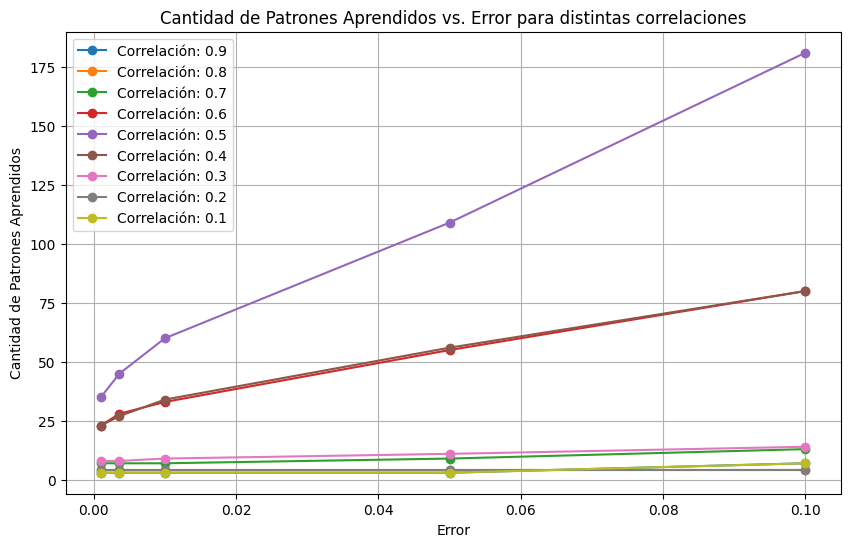

In [62]:

base_pattern = np.random.choice([-1, 1], size=(N))

corr_strengths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_patrones_corr_all = []

for corr_strength in corr_strengths:
    random_patterns_corr = np.zeros((MAXP, N))
    for i in range(MAXP):
        random_patterns_corr[i] = base_pattern.copy()
        num_changes = int(corr_strength * N)
        indexes = np.random.choice(N, num_changes, replace=False)
        random_patterns_corr[i][indexes] *= -1

    h2 = HopfieldNetwork(N)
    max_patrones_corr = []
    for error in max_errors:
        E = 0
        for i in range(1, MAXP):
            h2.weights = np.zeros((N, N))
            h2.train(random_patterns_corr[:i])
            ET = 0
            for j in range(i):
                h2.run_syncronically(random_patterns_corr[j])
                ET += np.sum(random_patterns_corr[j] != h2.run_syncronically(random_patterns_corr[j]))
            E = ET / (N * i)
            if E >= error:
                max_patrones_corr.append(i)
                break
    max_patrones_corr_all.append(max_patrones_corr)


plt.figure(figsize=(10, 6))
for i, corr_strength in enumerate(corr_strengths):
    plt.plot(max_errors, max_patrones_corr_all[i],'o-', label=f'Correlación: {round(1-corr_strength, 2)}')

plt.xlabel('Error')
plt.ylabel('Cantidad de Patrones Aprendidos')
plt.title('Cantidad de Patrones Aprendidos vs. Error para distintas correlaciones')
plt.legend()
plt.grid(True)
plt.show()
